# Context-Dependent Decision Making Task

This environment implements a context-dependent perceptual decision-making task, in which the agent has to perform a perceptual decision that depends on a context that is explicitly indicated on each trial. The environment is a simplified version of the original task ([Mante et al. 2013](https://www.nature.com/articles/nature12742)), that tests the agents' ability to flexibly switch between different contexts by making them choose between two options (left or right) based on the stimulus evidence associated with the relevant context (e.g., motion and color). The key features of the task are:

1. The relevant context is explicitly signaled on each trial.
2. Choices are represented as angles evenly spaced around a circle. Note that the number of choices can be configured via `dim_ring`. With the default of 2 choices, this corresponds to:

   - Position 1: 0° (left choice)
   - Position 2: 180° (right choice)

3. Stimulus for each context is represented as a cosine modulation peaked at one of these positions.
4. The correct choice (ground truth) is randomly chosen on each trials (for 2 choices: left or right).
5. The stimulus evidence (coherence) of each context is also randomly chosen on each trial.

For example, if the context signal indicates modality 0, the agent must:

- Choose position 1 (left) when context 0's coherence peaks at 0°
- Choose position 2 (right) when context 0's coherence peaks at 180°

In this notebook, we will:

1. Train an agent on the task using supervised learning and reinforcement learning with [Stable-Baselines3](https://stable-baselines3.readthedocs.io/).
2. Compare the behavior of agents trained with supervised learning and reinforcement learning.


# Training an Agent on the Context-Dependent Decision Making Task


## Part 0: Install Dependencies

To begin, install the `neurogym` package. This will automatically install all required dependencies, including Stable-Baselines3.

For detailed instructions on how to install `neurogym` within a conda environment or in editable mode, refer to the [installation instructions](https://github.com/neurogym/neurogym?tab=readme-ov-file#installation).


In [1]:
# Uncomment to install
# ! pip install neurogym

## Part 1: Environment Setup and Initial Agent Behavior

Let's now create and explore the environment using the `ContextDecisionMaking` class from neurogym. We'll use the default configuration for explicit context mode (`use_expl_context = True`) which includes:

- `dim_ring = 2`: Two possible choices (left/right) represented at 0° and 180°. Note that the ring architecture can support any number of choices, making it suitable for more complex decision-making scenarios. The environment will provide context signals indicating which modality is relevant for each trial, allowing the agent to flexibly adapt its decision strategy.
- `timing = {'fixation': 300, 'stimulus': 750, 'delay': ~600, 'decision': 100}` (in milliseconds).
- `rewards = {'abort': -0.1, 'correct': +1.0}`; abort is a penalty applied when the agent fails to fixate. The task allows the trial to be aborted if fixation does not occur, which is where the name of this penalty comes from.
- `sigma = 0.1`: Standard deviation of the noise added to the inputs.


### 1.1 Import Libraries


In [6]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import neurogym as ngym
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from neurogym.wrappers.monitor import Monitor
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv
from collections import Counter
import torch.nn as nn
import torch

# Suppress warnings
warnings.filterwarnings("ignore")

### 1.2 Environment Setup


In [ ]:
# Environment parameters (We are going to use the parameters to make kwargs that we can pass to gym.make())
EVAL_TRIALS = 1000
use_expl_context = True  # Use explicit context mode
# These are the default values, shown here to demonstrate how they can be modified:
dt = 100
dim_ring = 2  # Number of choices in the ring representation
abort = False  # Whether to allow aborting the trial if the agent does not fixate
rewards = {
    "abort": -0.1,
    "correct": +1.0,
    "fail": 0.0
}
timing = {
    "fixation": 300,
    "stimulus": 750,
    "delay": 0,
    "decision": 100,
}
sigma = 1.0 # Standard deviation of the Gaussian noise in the ring representation

# We can modify any of these parameters by passing them to gym.make(); kwargs are (keyword arguments) that we can use to pass parameters to the environment:
kwargs = {
    "use_expl_context": use_expl_context,
    "dt": dt,
    "dim_ring": dim_ring,
    "rewards": rewards,
    "timing": timing,
    "sigma": sigma,
    "abort": abort,
}

# Create and wrap the environment
task = "ContextDecisionMaking-v0"
env = gym.make(task, **kwargs)

# Check the custom environment and output additional warnings (if any)
check_env(env)

# Print environment specifications
print("Trial timing (in milliseconds):")
print(env.timing)

print("\nObservation space structure:")
print(env.observation_space)
print("Observation components:")
print(env.observation_space.name)

print("\nAction space structure:")
print(env.action_space)
print("Action mapping:")
print(env.action_space.name)

TypeError: ContextDecisionMaking.__init__() got an unexpected keyword argument 'use_expl_context' was raised from the environment creator for ContextDecisionMaking-v0 with kwargs ({'use_expl_context': True, 'dt': 100, 'dim_ring': 2, 'rewards': {'abort': -0.1, 'correct': 1.0, 'fail': 0.0}, 'timing': {'fixation': 300, 'stimulus': 750, 'delay': 0, 'decision': 100}, 'sigma': 1.0, 'abort': False})

### 1.3 Random Agent Behavior

Let's now plot the behavior of a random agent on the task. The agent will randomly choose between the two options (left/right, blue line), and we will visualize its behavior over 5 trials. We will also plot the reward received by the agent at each time step, as well as the performance on each trial. Note that performance is only defined at the end of a trial: it is 1 if the agent made the correct choice, and 0 otherwise.

To keep track of the agent's behavior, we will use the `Monitor` wrapper, which monitors training by:

- Tracking and saving behavioral data (rewards, actions, observations) every `sv_per` steps.
- Generating visualization figures during training if` sv_fig=True`.
- Providing progress information if `verbose=True`.

Here, we’ll use the wrapper solely to compute the agent’s performance, but later it will help us assess learning and save intermediate results.



Evaluating random policy performance...
Completed 1000/1000 trials

Random policy metrics (1,000 trials):
Mean performance: 0.3450
Mean reward: 0.3450


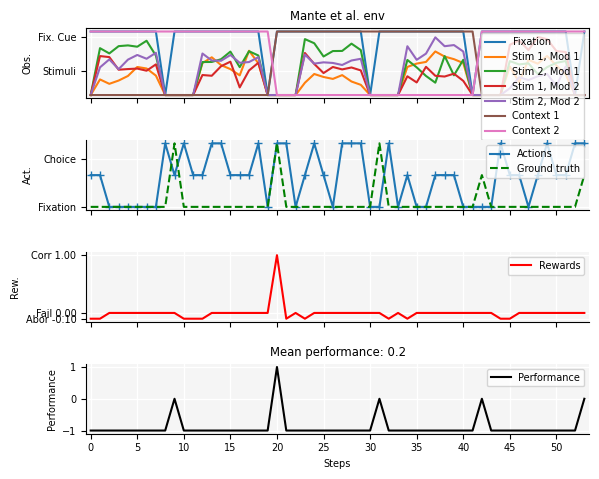

In [3]:
obs, info = env.reset()

# Visualize example trials
fig = ngym.utils.plot_env(
    env,
    name='Mante et al.',
    ob_traces=[
        'Fixation',
        'Stim 1, Mod 1',  # First stimulus component of modality 1
        'Stim 2, Mod 1',  # Second stimulus component of modality 1
        'Stim 1, Mod 2',  # First stimulus component of modality 2
        'Stim 2, Mod 2',  # Second stimulus component of modality 2
        'Context 1',      # First context signal
        'Context 2',      # Second context signal
    ],
    num_trials=5
)

# Evaluate performance of the environment before training
eval_monitor = Monitor(
    env,
    "./training_logs",
)
print("\nEvaluating random policy performance...")
metrics = eval_monitor.evaluate_policy(num_trials=EVAL_TRIALS)
print(f"\nRandom policy metrics ({EVAL_TRIALS:,} trials):")
print(f"Mean performance: {metrics['mean_performance']:.4f}")
print(f"Mean reward: {metrics['mean_reward']:.4f}")

As we can see, the agent's behavior is entirely random. It does not learn to fixate or to choose the correct option based on contextual cues. As a result, its performance is also random. Through training, we expect the agent to improve by learning to respect the fixation period, use context cues to infer the relevant context, and map signal peaks to the correct choices in the ring representation. Let’s move on to training the agent to see whether it can learn these key aspects of the task.


## Part 2: Training and Evaluating the Agent

We will now train the agent using Stable-Baselines3’s implementation of [PPO (Proximal Policy Optimization)](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html), a widely used reinforcement learning algorithm known for its stability and efficiency.

To support recurrent policies, we will use [RecurrentPPO](https://sb3-contrib.readthedocs.io/en/master/modules/ppo_recurrent.html#recurrent-ppo), which extends PPO with recurrent neural networks, specifically LSTMs.


### 2.1 Training the Agent


In [5]:
# Set the number of trials to train on
avg_timesteps = env.avg_timesteps_per_trial
TRAIN_TRIALS = 10000  # Choose the desired number of trials
total_timesteps = int(TRAIN_TRIALS * avg_timesteps)
print(f"Training for {TRAIN_TRIALS:,} trials ≈ {total_timesteps:,} timesteps")

# Configure monitoring with trial-appropriate parameters
trials_per_figure = 10  # Show 10 trials in each figure
steps_per_figure = int(trials_per_figure * avg_timesteps)

train_monitor = Monitor(
    env,
    folder="./training_logs/",
    sv_per=1000,         # Save data every 1000 trials
    sv_stp="trial",      # Save based on completed trials
    verbose=True,        # Print stats when data is saved
    sv_fig=True,         # Save visualization figures
    num_stps_sv_fig=steps_per_figure, # Number of steps per figure
    name="training_run"  # Name prefix for files
)

# DummyVecEnv is Stable-Baselines3 wrapper that converts the environment
# into a vectorized form (required by PPO), allowing for parallel training of multiple environments
env_vec = DummyVecEnv([lambda: train_monitor])

# Create and train Recurrent PPO agent
# Set n_steps to be a multiple of your average trial length
trials_per_batch = 64
n_steps = int(avg_timesteps * trials_per_batch)  # Collect approximately 64 trials per update
batch_size = 32  # Small batch size for short episodes
policy_kwargs = {
    "lstm_hidden_size": 64,  # Small LSTM for short sequences
    "n_lstm_layers": 1,      # Single layer is sufficient
    "shared_lstm": True,     # Share LSTM to reduce parameters
    "enable_critic_lstm": False,  # Disable separate LSTM for critic when sharing
}
rl_model = RecurrentPPO(
    "MlpLstmPolicy",
    env_vec,
    learning_rate=5e-4,       # Slightly higher for faster learning in short episodes
    n_steps=n_steps,          # Align with multiple complete episodes
    batch_size=32,            # Smaller batch size
    ent_coef=0.01,            # Promote exploration
    policy_kwargs=policy_kwargs,
    verbose=1
)

rl_model.learn(total_timesteps=total_timesteps, log_interval=int(total_timesteps/10))
env_vec.close()

Training for 10,000 trials ≈ 115,000 timesteps
Using cpu device
--------------------
Data saved to: training_logs/ContextDecisionMaking_bhvr_data_training_run_1000.npz
Number of trials: 1000
Average reward: 0.495
Average performance: 0.495
--------------------
--------------------
Data saved to: training_logs/ContextDecisionMaking_bhvr_data_training_run_2000.npz
Number of trials: 2000
Average reward: 0.77
Average performance: 0.77
--------------------
--------------------
Data saved to: training_logs/ContextDecisionMaking_bhvr_data_training_run_3000.npz
Number of trials: 3000
Average reward: 0.834
Average performance: 0.834
--------------------
--------------------
Data saved to: training_logs/ContextDecisionMaking_bhvr_data_training_run_4000.npz
Number of trials: 4000
Average reward: 0.849
Average performance: 0.849
--------------------
--------------------
Data saved to: training_logs/ContextDecisionMaking_bhvr_data_training_run_5000.npz
Number of trials: 5000
Average reward: 0.858
A

### 2.2 Plot the Behavior of the Trained Agent


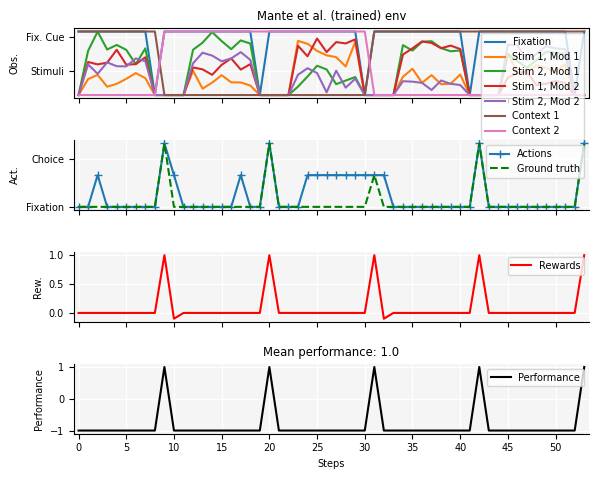

In [8]:
# Plot example trials with trained agent
fig = ngym.utils.plot_env(
    env_vec,
    name='Mante et al. (trained)',
    ob_traces=[
        'Fixation',
        'Stim 1, Mod 1',  # First stimulus component of modality 1
        'Stim 2, Mod 1',  # Second stimulus component of modality 1
        'Stim 1, Mod 2',  # First stimulus component of modality 2
        'Stim 2, Mod 2',  # Second stimulus component of modality 2
        'Context 1',      # First context signal
        'Context 2',      # Second context signal
    ],
    num_trials=5,
    model=rl_model,
)

After training, we visualize the agent's behavior on a few example trials. In contrast to the random agent, we should now see:

- Consistent fixation maintenance during the fixation period
- Choices that correlate with the evidence in the modality indicated by the context signal
- No systematic relationship between choices and signals from the irrelevant modality
- Performance significantly above chance level (0.5), reflecting successful context-dependent decisions

The plot shows the trained agent's behavior across 5 example trials, allowing us to visualize how well it has learned to flexibly switch its attention between modalities based on the context signal and make appropriate choices using the ring representation.


### 2.3 Evaluate the Agent's Performance



Evaluating trained model performance...
Completed 1000/1000 trials

Trained model metrics (1,000 trials):
Mean performance: 0.9260
Mean reward: 0.9260
Found 10 data files
Figure saved to training_logs/ContextDecisionMaking_training_history.png


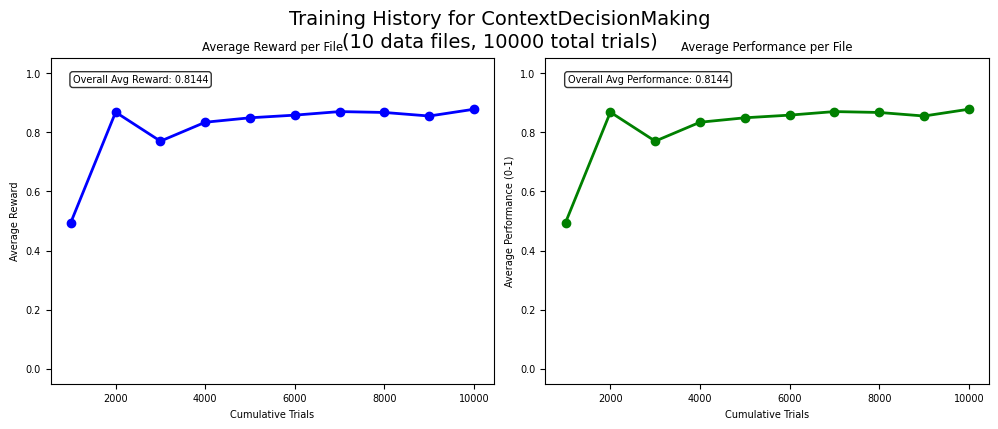

In [10]:
# Evaluate performance of the trained model
print("\nEvaluating trained model performance...")
rl_trained_metrics = eval_monitor.evaluate_policy(num_trials=EVAL_TRIALS, model=rl_model)
print(f"\nTrained model metrics ({EVAL_TRIALS:,} trials):")
print(f"Mean performance: {rl_trained_metrics['mean_performance']:.4f}")
print(f"Mean reward: {rl_trained_metrics['mean_reward']:.4f}")

fig = train_monitor.plot_training_history(figsize=(10, 4))

# Learning the Task as a Supervised Problem

We will now train the agent using supervised learning. NeuroGym provides functionality to generate a dataset directly from the environment, allowing us to sample batches of inputs and corresponding labels for training.


## Part 1: Converting the Environment to a Supervised Dataset


In [11]:
# Sample trials to understand the distribution
num_trials = 10000
trial_lengths = []
ground_truths = []

for _ in range(num_trials):
    env.new_trial()
    trial_lengths.append(env.ob.shape[0])  # Length of current trial
    ground_truths.extend(env.gt)

trial_lengths = np.array(trial_lengths)
avg_timesteps = np.mean(trial_lengths)
std_dev = np.std(trial_lengths)
max_length = np.max(trial_lengths)
percentile_95 = np.percentile(trial_lengths, 95)

print(f"Average timesteps per trial: {avg_timesteps:.2f} ± {std_dev:.2f}")
print(f"Maximum trial length: {max_length}")
print(f"95th percentile length: {percentile_95}")

# Set seq_len to capture 95% of trials
seq_len = round(percentile_95)
print(f"Using sequence length: {seq_len}")

gt_counter = Counter(ground_truths)
class_frequencies = {}
print("\nGround truth distribution:")
for gt, count in sorted(gt_counter.items()):
    print(f"Ground truth {gt}: {count} samples ({count/np.sum(trial_lengths)*100:.2f}%)")
    class_frequencies[int(gt)] = round(float(count / np.sum(trial_lengths)), 4)

class_weights = [1/freq for freq in class_frequencies.values()]
total_weight = sum(class_weights)
class_weights = [w/total_weight * len(class_weights) for w in class_weights]

Average timesteps per trial: 11.00 ± 0.00
Maximum trial length: 11
95th percentile length: 11.0
Using sequence length: 11

Ground truth distribution:
Ground truth 0: 100000 samples (90.91%)
Ground truth 1: 5021 samples (4.56%)
Ground truth 2: 4979 samples (4.53%)


In [12]:
# Environment parameters
task = 'ContextDecisionMaking-v0'
kwargs = {
    "use_expl_context": use_expl_context,
    "dt": dt,
    "dim_ring": dim_ring,
    "rewards": rewards,
    "timing": timing,
    "sigma": sigma,
    "abort": abort,
}

# Make supervised dataset
print(f"Creating dataset with batch_size={batch_size}")
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=batch_size, seq_len=seq_len*2)

env = dataset.env

# Extract dimensions from environment
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n

print(f"Observation size: {ob_size}")
print(f"Action size: {act_size}")

# Get a batch of data
inputs, target = dataset()

# Display shapes and content
print(f"Input batch shape: {inputs.shape}")
print(f"Target batch shape: {target.shape}")

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Creating dataset with batch_size=32
Observation size: 7
Action size: 3
Input batch shape: (22, 32, 7)
Target batch shape: (22, 32)
Using device: cpu


In [13]:
# Define the LSTM model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=False)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        # Forward pass with hidden state tracking
        lstm_out, hidden = self.lstm(x, hidden)
        output = self.fc(lstm_out)
        return output, hidden

    def init_hidden(self, batch_size, device):
        """Initialize hidden state"""
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        return (h0, c0)

# Create the model
hidden_size = 128
sl_model = Net(
    input_size=ob_size,
    hidden_size=hidden_size,
    output_size=act_size,
).to(device)

## Part 2: Training and Evaluating a Neural Network Model


Epoch [0/1000], Loss: 1.1019
Epoch [50/1000], Loss: 0.6693
Epoch [100/1000], Loss: 0.3996
Epoch [150/1000], Loss: 0.3807
Epoch [200/1000], Loss: 0.2490
Epoch [250/1000], Loss: 0.2222
Epoch [300/1000], Loss: 0.3381
Epoch [350/1000], Loss: 0.1122
Epoch [400/1000], Loss: 0.1078
Epoch [450/1000], Loss: 0.1155
Epoch [500/1000], Loss: 0.1265
Epoch [550/1000], Loss: 0.1311
Epoch [600/1000], Loss: 0.0480
Epoch [650/1000], Loss: 0.1583
Epoch [700/1000], Loss: 0.1017
Epoch [750/1000], Loss: 0.1001
Epoch [800/1000], Loss: 0.0717
Epoch [850/1000], Loss: 0.2340
Epoch [900/1000], Loss: 0.1832
Epoch [950/1000], Loss: 0.1120
Finished Training


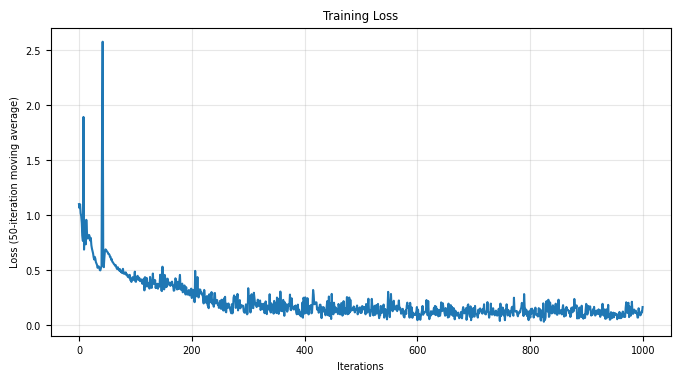

In [14]:
class_weights = torch.tensor(class_weights).to(device)
optimizer = torch.optim.Adam(sl_model.parameters(), lr=0.01, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(weight=class_weights)
EPOCHS = 1000
# Training loop
loss_history = []

for i in range(EPOCHS):
    # Get a batch of data
    inputs, targets = dataset()

    # Convert to PyTorch tensors
    inputs = torch.from_numpy(inputs).float().to(device)
    targets = torch.from_numpy(targets).long().to(device)

    # Initialize hidden state
    hidden = sl_model.init_hidden(inputs.size(1), device)

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass with hidden state tracking
    outputs, _ = sl_model(inputs, hidden)

    # Reshape for CrossEntropyLoss
    outputs_flat = outputs.reshape(-1, outputs.size(2))
    targets_flat = targets.reshape(-1)

    # Calculate loss
    # Weight the loss to account for class imbalance (very low weight to 0s, higher weights to 1s and 2s)
    loss = criterion(outputs_flat, targets_flat)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # print statistics
    loss_history.append(loss.item())
    if i % 50 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(i, EPOCHS, loss.item()))

print('Finished Training')

# Plot the loss curve
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss (50-iteration moving average)')
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
verbose = False
# Evaluate performance of the trained model
sl_model.eval()

total_correct = 0
total_trials = 0

# Evaluate for specified number of trials
print(f"Evaluating model performance across {EVAL_TRIALS} trials...")

for i in range(EVAL_TRIALS):
    # Generate a new trial
    env.new_trial()
    ob, gt = env.ob, env.gt
    if verbose:
        print("observation shape:", ob.shape)
        print("ground truth shape:", gt.shape)

    # Handle potentially variable-length trials
    trial_length = ob.shape[0]

    # Add batch dimension to observation
    ob = ob[:, np.newaxis, :]

    # Convert to tensor
    inputs = torch.from_numpy(ob).float().to(device)
    if verbose:
        print("inputs shape:", inputs.shape)

    # Initialize hidden state for new trial
    hidden = sl_model.init_hidden(1, device)

    with torch.no_grad():
        outputs, _ = sl_model(inputs, hidden)
        pred_actions = torch.argmax(outputs, dim=2)
        if verbose:
            print("outputs shape:", outputs.shape)
            print("predicted actions shape:", pred_actions.shape)
            print("predicted actions:", pred_actions)
            print("ground truth:", gt)

    # Check only the decision period
    decision_idx = trial_length - 1  # Assuming decision is at the end
    is_correct = (gt[decision_idx] == pred_actions[decision_idx, 0].cpu().numpy())

    total_correct += is_correct

    if (i+1) % 100 == 0:
        print(f"Completed {i+1}/{EVAL_TRIALS} trials | Accuracy: {total_correct/(i+1):.4f}")

# Calculate mean performance
sl_mean_performance = total_correct / EVAL_TRIALS

print(f"Mean performance across {EVAL_TRIALS} trials: {sl_mean_performance:.4f}")

Evaluating model performance across 1000 trials...
Completed 100/1000 trials | Accuracy: 0.9300
Completed 200/1000 trials | Accuracy: 0.9200
Completed 300/1000 trials | Accuracy: 0.9200
Completed 400/1000 trials | Accuracy: 0.9250
Completed 500/1000 trials | Accuracy: 0.9280
Completed 600/1000 trials | Accuracy: 0.9350
Completed 700/1000 trials | Accuracy: 0.9300
Completed 800/1000 trials | Accuracy: 0.9263
Completed 900/1000 trials | Accuracy: 0.9278
Completed 1000/1000 trials | Accuracy: 0.9290
Mean performance across 1000 trials: 0.9290


# Comparing RL and SL Approaches


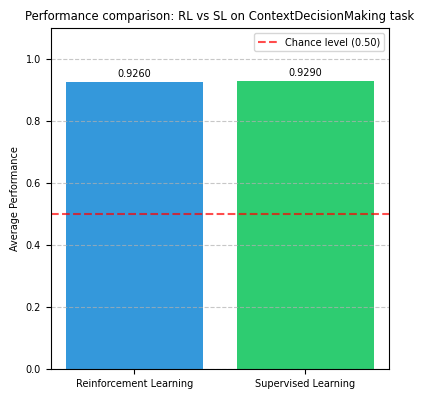

RL model performance: 0.9260
SL model performance: 0.9290
Difference (RL - SL): -0.0030


In [16]:
rl_performance = rl_trained_metrics['mean_performance']
sl_performance = sl_mean_performance

# Create a simple bar plot to compare performances
plt.figure(figsize=(4, 4))
models = ['Reinforcement Learning', 'Supervised Learning']
performances = [rl_performance, sl_performance]

# Create bar plot
bars = plt.bar(models, performances, color=['#3498db', '#2ecc71'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

# Customize plot
plt.ylim(0, 1.1)  # Performance ranges from 0 to 1
plt.ylabel('Average Performance')
plt.title('Performance comparison: RL vs SL on ContextDecisionMaking task')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line at chance level performance (if applicable)
chance_level = 1.0 / (act_size - 1)  # Assuming fixation (action 0) doesn't count for performance
plt.axhline(y=chance_level, linestyle='--', color='red', alpha=0.7,
            label=f'Chance level ({chance_level:.2f})')
plt.legend()

plt.tight_layout()
plt.show()

# Print numerical comparison
print(f"RL model performance: {rl_performance:.4f}")
print(f"SL model performance: {sl_performance:.4f}")
print(f"Difference (RL - SL): {rl_performance - sl_performance:.4f}")